Este cuaderno incluye el código utilizado para el ejemplo: Restauración de imágenes con ruido sal y pimienta de la sección 2.6.2 del documento.

# Módulos

In [11]:
from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.examples import spnoise
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
from scipy.ndimage import median_filter
plot.config_notebook_plotting()
from skimage import data, color
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.transform import resize

## Funciones auxiliares

In [2]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

# Restauración de imágenes con ruido sal y pimienta

In [3]:
# Importamos la imagen de prueba y le añadimos ruido
imagen = color.rgb2gray(data.astronaut())
x_gt = imagen

y = spnoise(x_gt, 0.25)

In [4]:
# Definimos la función de costo y la regularización
λ = 0.6e0
g_loss = loss.Loss(y=y, f=functional.L1Norm())
g_tv = λ * functional.L21Norm()
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)

solver = ADMM(
    f=None,
    g_list=[g_loss, g_tv],
    C_list=[linop.Identity(input_shape=y.shape), C],
    rho_list=[5e0, 5e0],
    x0=y,
    maxiter=500,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 20}),
    itstat_options={"display": True, "period": 10},
)

print(f"Solving on {device_info()}\n")
x_tv = solver.solve()
hist = solver.itstat_object.history(transpose=True)

c:\Users\matda\AppData\Local\Programs\Python\Python311\Lib\site-packages\scico\numpy\_wrappers.py:89: UserWarning: Explicitly requested dtype float64 requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return func(*args, **kwargs)  # no mapping


Solving on CPU

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  9.83e-01  4.850e+04  1.059e+02  4.936e+02      0  0.000e+00
  10  2.29e+00  4.460e+04  8.672e+00  1.710e+02      6  6.795e-04
  20  3.43e+00  3.848e+04  8.954e+00  9.873e+01      6  6.829e-04
  30  4.50e+00  3.749e+04  4.474e+00  3.181e+01      5  5.332e-04
  40  5.42e+00  3.743e+04  2.352e+00  1.333e+01      4  5.142e-04
  50  6.23e+00  3.745e+04  1.572e+00  7.367e+00      3  5.743e-04
  60  6.97e+00  3.747e+04  1.086e+00  4.262e+00      2  7.973e-04
  70  7.70e+00  3.748e+04  8.607e-01  2.462e+00      1  9.721e-04
  80  8.34e+00  3.749e+04  6.700e-01  1.688e+00      1  7.656e-04
  90  8.95e+00  3.750e+04  5.844e-01  9.233e-01      1  8.900e-04
 100  9.56e+00  3.751e+04  4.926e-01  7.654e-01      1  7.692e-04
 110  1.02e+01  3.751e+04  4.232e-01  6.954e-01      1  6.942e-04
 120  1.08e+01  3.751e+04  3.699e-01  6.430e-01      1  6.41

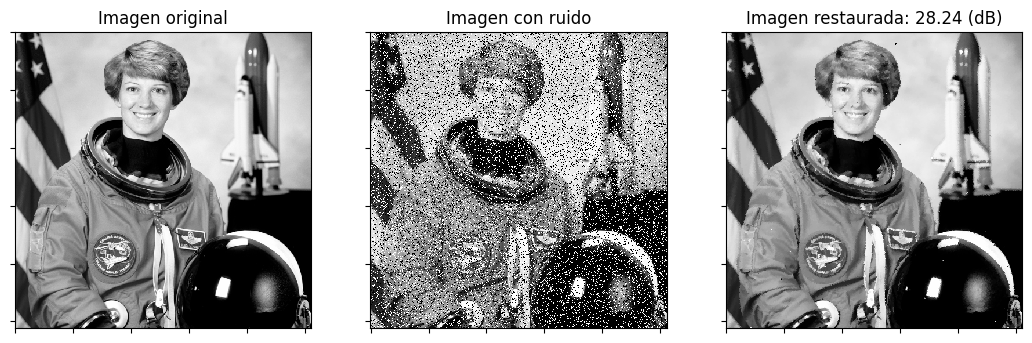

In [9]:
# Visualizamos los resultados
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.0))
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(13, 12))
plot.imview(x_gt, title="Imagen original", fig=fig, ax=ax[0], **plt_args)
plot.imview(y, title="Imagen con ruido", fig=fig, ax=ax[1], **plt_args)
plot.imview(
    x_tv,
    title=f"Imagen restaurada: {metric.psnr(x_gt, x_tv):.2f} (dB)",
    fig=fig,
    ax=ax[2],
    **plt_args,
)
fig.show()

In [12]:
# calculamos las métricas entre la imágen original, la imagen ruidosa y la imagen sin ruido
ssim_ruidosa = structural_similarity(
    normalize(x_gt),
    normalize(resize(y, (512, 512), anti_aliasing=True)),
    data_range=1,
)
ssim_restaurada = structural_similarity(
    normalize(x_gt), normalize(np.array(x_tv)), data_range=1
)
psnr_ruidosa = peak_signal_noise_ratio(
    normalize(x_gt), resize(y, (512, 512), anti_aliasing=True), data_range=1
)
psnr_restaurada = peak_signal_noise_ratio(
    normalize(x_gt), normalize(np.array(x_tv)), data_range=1
)

print(f"SSIM entre la imagen original y la imagen ruidosa: {ssim_ruidosa}")
print(f"SSIM entre la imagen original y la imagen restaurada: {ssim_restaurada}")
print(f"PSNR entre la imagen original y la imagen ruidosa: {psnr_ruidosa}")
print(f"PSNR entre la imagen original y la imagen restaurada: {psnr_restaurada}")

SSIM entre la imagen original y la imagen ruidosa: 0.10943734953162838
SSIM entre la imagen original y la imagen restaurada: 0.9301094378450845
PSNR entre la imagen original y la imagen ruidosa: 10.699434881938867
PSNR entre la imagen original y la imagen restaurada: 28.24227168543547
